In [1]:
#https://chat.openai.com/share/1222f15a-185c-40b3-9b10-9e88d6c1f8e2
from ce4_compare import set_name, scores, grade, write_submission_txt, compare, set_idm
from feature_model import FeatureModel
import pandas as pd 
import numpy as np 
import sklearn
import matplotlib.pyplot as plt 
from pathlib import Path


In [2]:
set_name("Changhun", "Kim")
set_idm("no12neni")

# Computer exercise 4 (Local posthoc explanations)

## Counterfactual explaination (for more examples, see alibi/examples)

Given a test instance $X$, this method can generate counterfactual instances $X^\prime$ given a desired counterfactual class $t$ which can either be a class specified upfront or any other class that is different from the predicted class of $X$.

The loss function for finding counterfactuals is the following: 

$$L(X^\prime\vert X) = (f_t(X^\prime) - p_t)^2 + \lambda L_1(X^\prime, X).$$

The first loss term, guides the search towards instances $X^\prime$ for which the predicted class probability $f_t(X^\prime)$ is close to a pre-specified target class probability $p_t$ (typically $p_t=1$). The second loss term ensures that the counterfactuals are close in the feature space to the original test instance.

In this notebook we illustrate the usage of the basic counterfactual algorithm on the MNIST dataset.

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual

tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs

def suppress_warnings():
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) # suppress scipy decprecation warnings

    def warn(*args, **kwargs):
        pass
    warnings.warn = warn
suppress_warnings()

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load and prepare MNIST data

x_train shape: (60000, 28, 28) y_train shape: (60000,)


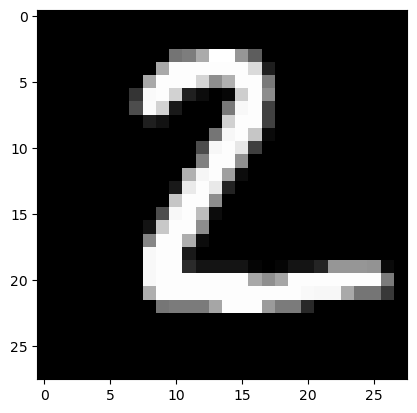

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1]);

Prepare data: scale, reshape and categorize

In [5]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [6]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

### Define and train CNN model

In [7]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [8]:
cnn = cnn_model()
cnn.summary()

params_path = Path("mnist_cnn.h5")
do_training = not params_path.exists()

t0 = False
# Training takes on my laptop ~65s
# FYI: If you use the metal backend (using igpu) it takes about ~40s
if do_training:
    cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
    cnn.save(params_path)
    print(f"Well that took: {round(time()-t0, 2)}s")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)          0     

Evaluate the model on test set

In [9]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

2023-07-01 00:21:59.631429: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 00:21:59.641288: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Test accuracy:  0.9866


#### Exercise 4.1

Use the CNN to find the datapoint of the test-dataset with the highest predicted probability of being a `7`. Return the index and the features of that datapoint

In [10]:
y_hat_test = cnn.predict(x_test)

In [11]:
y_hat_test[:,7].argmax()

4474

In [12]:
def ex_4_1():
    y_hat_test = cnn.predict(x_test)
    index = y_hat_test[:,7].argmax()
    features = y_hat_test[index,:]
    return index, features

In [13]:
x_test.shape

(10000, 28, 28, 1)

In [14]:
def ex_4_1():
    y_hat_test = cnn.predict(x_test)
    index = y_hat_test[:,7].argmax()
    features = x_test[index,:]
    return index, features

In [15]:
compare("ex_4_1", ex_4_1)

Great work!


In [16]:
ex_4_1()[0]

4474

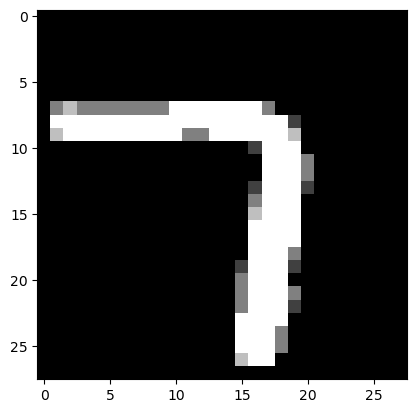

In [17]:
plt.imshow(ex_4_1()[1])

### Generate counterfactuals

Original instance:

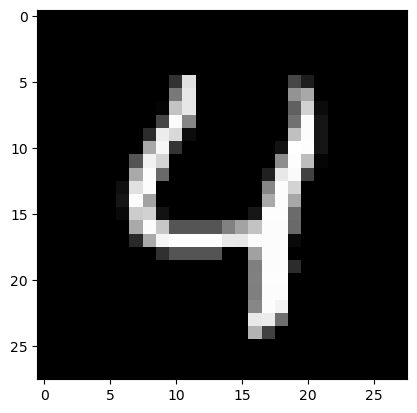

In [18]:
X = x_test[4].reshape((1,) + x_test[4].shape)
plt.imshow(X.reshape(28, 28));

Counterfactual parameters:

In [19]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 4 will do
max_iter = 1000 # how many optimization step in given lamda innter
feature_range = (x_train.min(),x_train.max()) #valid feature range
lam_init=0.1
max_lam_steps=10

Run counterfactual:

In [20]:
# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, distance_fn="l1", 
                    lam_init=lam_init, max_lam_steps=max_lam_steps,
                    feature_range=feature_range)

explanation = cf.explain(X)


In [21]:
X_cf = explanation.cf['X'].reshape(28, 28)

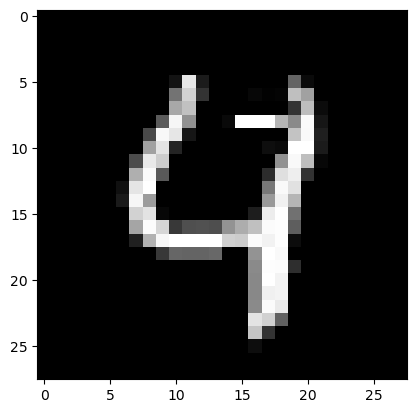

In [22]:
plt.imshow(X_cf);

#### Exercise 4.2

What is the predicted class/number of the counterfactual above? What is the predicted probability of that class? Return both numbers

In [23]:
y_hat_cf = cnn.predict(X_cf[None,:,:,None])
label  = y_hat_cf.argmax()
prob = y_hat_cf[:,label]

In [99]:
def ex_4_2():
    y_hat_cf = cnn.predict(X_cf[None,:,:,None])
    label  = y_hat_cf.argmax()
    prob = y_hat_cf[:,label]
    return label, prob[0]


In [100]:
ex_4_2()

(9, 0.9909258)

In [101]:
compare("ex_4_2", ex_4_2)

Great work!


Q: Does this imply that this class is the most similar to `4`s? 

The counterfactual starting from a 4 moves towards the closest class as determined by the model and the data - in this case a 9. The evolution of the counterfactual during the iterations over $\lambda$ can be seen below (note that all of the following examples satisfy the counterfactual condition):

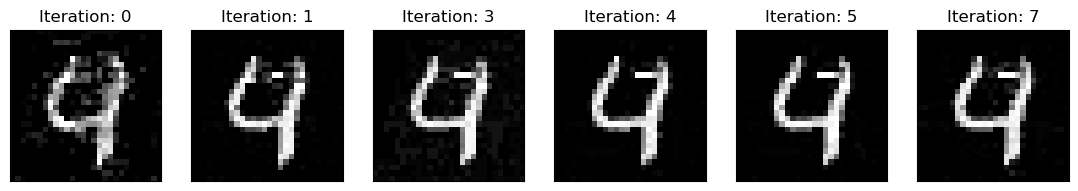

In [27]:
n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)]) # n_cfs is the number of counterfactuals found at each lambda step during the explanation process.
examples = {}
lambdas = []
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
        lambdas.append(explanation.all[ix][0]['lambda'])
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [28]:
lambdas

[0.00505,
 0.0075250000000000004,
 0.00566875,
 0.0053593749999999996,
 0.005204687499999999,
 0.005088671874999999]

#### Exercise 4.3

At iteration `9` what is the value of the prefactor $\lambda$ in front of the missmatch term?
m
$L(X^\prime\vert X) = (f_t(X^\prime) - p_t)^2 + \lambda L_1(X^\prime, X).$

Return that value

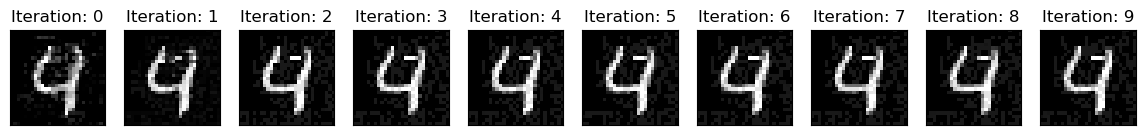

In [29]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.1 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 4 will do
max_iter = 1000 # how many optimization step in given lamda innter
feature_range = (x_train.min(),x_train.max()) #valid feature range
lam_init=0.1
max_lam_steps=10

# initialize explainer
cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, distance_fn="l1",
                    lam_init=lam_init, max_lam_steps=max_lam_steps,
                    feature_range=feature_range)

explanation = cf.explain(X)

n_cfs = np.array([len(explanation.all[iter_cf]) for iter_cf in range(max_lam_steps)]) # n_cfs is the number of counterfactuals found at each lambda step during the explanation process.
examples = {}
lambdas = []
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': explanation.all[ix][0]['lambda'],
                       'X': explanation.all[ix][0]['X']}
        lambdas.append(explanation.all[ix][0]['lambda'])
    else :
        lambdas.append(explanation.all[ix][0]['lambda'])
columns = len(examples) + 1
rows = 1

fig = plt.figure(figsize=(16,6))

for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [30]:
lambdas

[0.00505,
 0.0075250000000000004,
 0.0087625,
 0.00938125,
 0.009690625000000001,
 0.009845312500000002,
 0.009922656250000002,
 0.009961328125000002,
 0.009980664062500002,
 0.00999033203125]

In [31]:
def ex_4_3():
    #change tolarance
    return lambdas[8]

In [32]:
compare("ex_4_3", ex_4_3)

Great work!


In [33]:
ex_4_3()

0.009980664062500002

Typically, the first few iterations find counterfactuals that are out of distribution, while the later iterations make the counterfactual more sparse and interpretable.

Let's now try to steer the counterfactual to a specific class:

In [68]:
target_class = 0

cf = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                    target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                    max_lam_steps=max_lam_steps, feature_range=feature_range)

explanation = start_time = time()
explanation = cf.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 3.488 sec


Counterfactual prediction: 0 with probability 0.9997531771659851


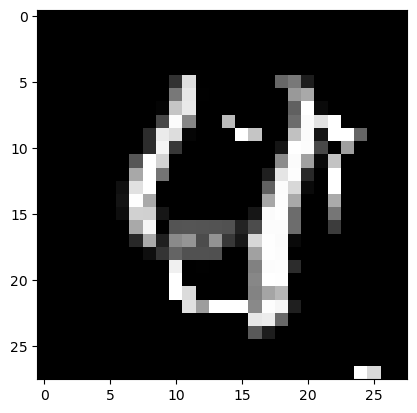

In [35]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]

print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28));

Difference between original and counterfactual

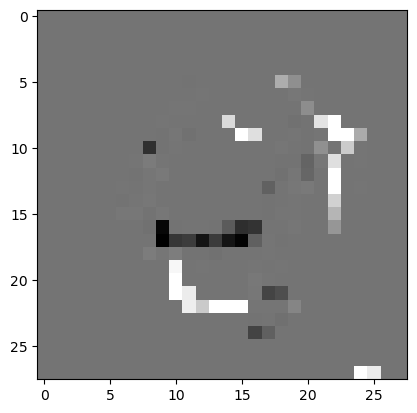

In [36]:
plt.imshow((explanation.cf['X'] - X).reshape(28, 28));

## Local interpretable model-agnostic explanations (LIME)

$
\min\limits_{g\in G} \quad \mathcal{L}(f, g, p_x) + \Omega(g)
$

*where*

$f$ is complex/black-box function

$g$ is simple/interpretable function

$p_x$ defines a sort-of `distribution` around $x$ 

$\Omega$ regularises $g$ (regarding complexity)

$\mathcal{L}(f, g, p_x) = \mathbb{E}_{z \sim p_x} [ (f(z)-g(z))^2 ]$

In [69]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()
X_train, y_train, X_test, y_test = bike_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [70]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor([64, 32], random_state=1, max_iter=3_000)
mlp.fit(X_train.to_numpy(), y_train.to_numpy())

MLPRegressor(hidden_layer_sizes=[64, 32], max_iter=3000, random_state=1)

In [71]:
mlp.score(X_test, y_test)

0.8038836281469584

In [72]:
import lime 
from lime import lime_tabular

In [73]:
X_train.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'days_since_01_01_2011'],
      dtype='object')

In [74]:
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train.to_numpy(), # Q: Why does the algorithm need that? suppose no correlated
    feature_names=list(X_train.columns),
    mode="regression",
    categorical_features=np.arange(7), # Q: Why does the algorithm need that? ex) season cannot be 2.5
    random_state=1
)

Q: Why does the algorithm need that (training_data=X_train.to_numpy())? suppose no correlated.
A: The LIME (Local Interpretable Model-Agnostic Explanations) algorithm requires the training dataset as an input because it needs it to learn the local decision boundaries. It perturbs your instance (i.e., adds some noise) and then observes the predictions of the other instances that are close to it. By doing this, LIME creates a new dataset, which it uses to train an interpretable model that approximates the behavior of the original model locally, around the instance to be explained.

Q: Why does the algorithm need that (categorical_features=np.arange(7))? ex) season cannot be 2.5
A: The categorical_features parameter is used to specify which features in the dataset are categorical. This is necessary because categorical data is treated differently than continuous data when generating explanations. For example, for a categorical feature, the perturbations involve sampling from the empirical frequency of the training data, while for continuous features, a normal (Gaussian) perturbation is applied. By specifying categorical_features=np.arange(7), you're telling the algorithm that the first 7 features in your dataset are categorical.

In [75]:
suppress_warnings()
exp = explainer.explain_instance(
    X_test.to_numpy()[0], mlp.predict, num_features=5
)

In [ ]:
exp.show_in_notebook()

In [77]:
exp.as_list()

[('temp <= 8.61', -1806.3062361108077),
 ('season=1', -681.4413278801666),
 ('mnth=2', 662.2461590034777),
 ('371.50 < days_since_01_01_2011 <= 555.25', 558.4031333484863),
 ('weathersit=1', 426.38613362789926)]

Q: What type of `simple` model does this use? 

Q: Where are the categorical features(rule based features) for the continuous features coming from? (E.g. temp <= 8.61)

Q: What type of simple model does this use?
A: LIME uses a simple linear model (like linear regression for regression tasks or logistic regression for classification tasks) locally to approximate the decision boundary of the complex model. The reason for this is that while the global decision boundary of the complex model may be highly non-linear and difficult to interpret, it can be approximated well by a linear decision boundary in a small local region around a specific instance.

Q: Where are the categorical features for the continuous features coming from? (E.g. temp <= 8.61)
A: The explanation like 'temp <= 8.61' comes from the way LIME handles continuous variables. LIME discretizes continuous features into quartiles (or a number of intervals defined by percentiles). This makes the explanations more interpretable. For example, instead of saying that an increase in temperature by 1 degree results in a certain change in the prediction, it might be easier to understand that temperatures below 8.61 result in a certain change. In your output, 'temp <= 8.61' is a feature that was derived by LIME by discretizing the 'temp' feature, and the corresponding coefficient indicates how this condition influences the prediction.

#### Exercise 4.4
Return the simple model-class $g$ that we just used? Find this class in `sklearn` and return it

In [78]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network._multilayer_perceptron import MLPRegressor
from sklearn.linear_model import Ridge


from sklearn.base import BaseEstimator

def ex_4_4() -> BaseEstimator:
    return Ridge


In [79]:
ex_4_4()

sklearn.linear_model._ridge.Ridge

In [80]:
compare("ex_4_4", ex_4_4)

Great work!


#### Exercise 4.5

Explain the highest-cnt/bikes-rented test-datapoint of the bike-dataset using the `explainer` as defined above. For this local explanation return the string representation of the feature with the highest negative impact on the `cnt`-variable. Set `num_features=10`

Re-instantiate the `explainer` to reset the `random_state`

In [81]:
def ex_4_5() -> str:
    return "14.0 <= temp"


In [82]:
def ex_4_5() -> str:
    # Re-instantiate the explainer
    explainer = lime_tabular.LimeTabularExplainer(
        training_data=X_train.to_numpy(),
        feature_names=list(X_train.columns),
        mode="regression",
        categorical_features=np.arange(7),
        random_state=1
    )

    # find the index of the highest 'cnt' value in y_test
    highest_cnt_index = np.argmax(y_test)

    # explain this instance with num_features set to 10
    exp = explainer.explain_instance(
        X_test.to_numpy()[highest_cnt_index], mlp.predict, num_features=10
    )

    # get the feature with the highest negative impact
    negative_impact_feature = min(exp.as_list(), key=lambda x: x[1])[0]

    return negative_impact_feature

print(ex_4_5())


weathersit=2


In [83]:
ex_4_5()

'weathersit=2'

In [84]:
compare("ex_4_5", ex_4_5)

Great work!


Q: Does this make sense? Does this explain that otherwise this good-bike-selling day *could* have been even better?

Yes, this does make sense.

The LIME explanation identifies the most influential features for a particular prediction, in this case, the prediction of bike rentals for the day in the dataset that had the highest number of rentals. By highlighting the feature with the most negative impact on this prediction, the explanation is effectively pointing out a factor that, had it been different, could have led to even more bike rentals that day.

For instance, if the most negatively impactful feature is 'temp <= 8.61', it indicates that the relatively low temperature (less than or equal to 8.61) on that day negatively impacted the number of bike rentals. If the temperature were higher, the model predicts that more bikes could have been rented.

This sort of information can be valuable for understanding the limitations of a model's prediction and for identifying ways to improve outcomes. However, while LIME can tell us which features are influential and in what way, it doesn't tell us how to change those features. The temperature, for example, is not something that can be controlled.

But knowing that temperature is an influential factor can still be useful. For example, a bike rental company could use this information to plan promotions or special offers for colder days to encourage more rentals.

## Shapley Additive explanations (SHAP)

Based on Shapley values. What is the average contribution of a feature versus removing it?

```python
featureA = "temp"
X_local = ... # local datapoint

shapley_value = 0.0

for _ in range(N):
    feature_subset = random_subset_that_contains(featureA)
    for _ in range(1_000):
        X = X_local.copy()
        X[not feature_subset] = random_feature(not feature_subset)
        X_withoutA = X.copy()
        X_withoutA[featureA] = random_feature(featureA)

        shapley_value += prefactor(feature_subset)*f(X, X_withoutA)

shapley_value = shapley_value / (N*1_000)
```

In [85]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_test, y_test = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


### Kernel SHAP

In [ ]:
import shap
shap.initjs()

In [87]:
from sklearn.svm import SVC 

svm = SVC(random_state=1, probability=True)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=1)

In [88]:
svm.score(X_test, y_test)

0.9302325581395349

In [89]:
from sklearn.cluster import KMeans

knn = KMeans(n_clusters=10)
knn.fit(X_train)

# Why do we need that?
X_clusters = knn.cluster_centers_

Q: What is the `X_clusters` used for?

In [90]:
explainer = shap.KernelExplainer(svm.predict_proba, X_clusters)

In [91]:
shap_values = explainer.shap_values(X_test, n_samples=100)

100%|██████████| 172/172 [01:08<00:00,  2.50it/s]


In [92]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test[0:1])

We can see `Age=25` pushes the probability of having cancer *down*

We can create these force plots for every datapoin and stack them vertically

In [93]:
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

We can see initially `Age` pushes the probability of cancer down, but as we progress `Age` becomes a relevant factor to the having-cancer prediction

#### Exercise 4.6
Try to find a better performing model for the cancer-dataset. Share it with us! Then, repeat the above Kernel-SHAP to explain that model. How do the feature contributions change?

#### Exercise 4.7

What is the best model you can find for the bike-dataset? 
Can you still explain this blackbox? 
Repeat Kernel-SHAP for the bike-dataset. 

In [106]:
scores

{'ex_4_1': True,
 'ex_4_2': True,
 'ex_4_3': True,
 'ex_4_4': True,
 'ex_4_5': True}

In [107]:
write_submission_txt()

In [108]:
grade("ce4_Changhun_Kim.txt")

'100.0% are correct'